---
title: Detecting aerosolized fluorophores with Rapid-E
subtitle: "Classifying bacterial-enriched bioaerosols with Rapid-E and ML"

authors:
  - name: "Alejandro Fontal"
    affiliation: "Climate & Health Program, ISGlobal"
    affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
    email: "alejandro.fontal.92@gmail.com"
    url: "https://alfontal.dev"
    orcid: 0000-0003-1138-2158
  - name: "Sílvia Borràs Aiguadé"
    affiliation: "AIRLAB, Climate & Health Program, ISGlobal"
    affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
    email: "silvia.borras@isglobal.org"
    orcid: 0000-0002-0331-0720
  - name: "Sofya Pozdniakova"
    affiliation: "AIRLAB, Climate & Health Program, ISGlobal"
    affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
    email: "sofya.pozdniakova@isglobal.org"
    orcid: 0000-0001-5849-1787
  - name: "Lídia Cañas"
    orcid: 0000-0002-1101-2694
    affiliations:
      - name: "AIRLAB, Climate & Health Program, ISGlobal"
        affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
      - name: "Department of Evolutionary Biology, Ecology and Environmental Sciences, University of Barcelona"
        affiliation-url: "https://www.ub.edu/web/ub/en/"
    email: "lcanas@ub.edu"
  - name: "Xavier Rodó"
    orcid: 0000-0003-4843-6180
    email: "xavier.rodo@isglobal.org"
    affiliations:
      - name: "Climate & Health Program, ISGlobal"
        affiliation-url: "https://www.isglobal.org/en/-/clima-y-salud"
      - name: "Catalonia Institute for Advanced Studies"
        affiliation-url: "https://www.icrea.cat/en/"

date: "last-modified"
format:
  html:
    warning: false
    smooth-scroll: true
    toc: true
    toc-location: right
    number-sections: false
---

## Preamble

### Imports

In [ ]:
import os
import sys
import bz2
import pickle

In [3]:
sys.path.append('..')
sys.path.append('../../aerosolpy')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt

from glob import glob
from tqdm.auto import tqdm
from functools import partial
from collections import defaultdict
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from aerosolpy.conversion import Conversion
from aerosolpy.particles import AerosolParticlesData, ParticleData
from aerosolpy.particles import (CORRECTED_SPECTRAL_WAVELENGTHS,
                                 WAVELENGTH_LIFETIME_RANGES,
                                 SCATTERING_ANGLES)

### Config

In [5]:
# Matplotlib settings
from matplotlib_inline.backend_inline import set_matplotlib_formats
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['svg.fonttype'] = 'none'
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300
# Plotnine settings (for figures)

p9.options.set_option('base_family', 'Georgia')

p9.theme_set(
    p9.theme_bw()
    + p9.theme(panel_grid=p9.element_blank(),
               legend_background=p9.element_blank(),
               panel_grid_major=p9.element_line(size=.5, linetype='dashed',
                                                alpha=.15, color='black'),
               dpi=300
    )
)

## Loading Data

In [70]:
for folder in glob('../data/fluorophores/*'):
    fluorophore = os.path.basename(folder)
    if os.path.exists(f'{folder}/particles.pickle.bz2'):
        continue
    else: 
        for filename in glob(f'{folder}/*.zip'):
            converter = Conversion(filename, mode='user', keep_threshold=True, keep_zip=True)
            converter.save_overall()
        particles = AerosolParticlesData.from_folder(folder)
        with bz2.BZ2File(f'{folder}/particles.pickle.bz2', 'w') as fh:
            pickle.dump(particles, fh)

In [7]:
particles_dict = {}
for folder in glob('../data/fluorophores/*'):
    fluorophore = os.path.basename(folder)
    with bz2.BZ2File(f'{folder}/particles.pickle.bz2', 'r') as fh:
        particles = pickle.load(fh)
    particles_dict[fluorophore] = particles

In [8]:
summary_df = []
for fluorophore, particles in particles_dict.items():
    summary_df.append(particles.summary_df.assign(fluorophore=fluorophore))
summary_df = pd.concat(summary_df)

In [9]:
(summary_df
 .replace({'fluorophore': {'Riboflavin+acetic': 'Riboflavin\n[AcOH]'}})
 .assign(fluorescent=lambda dd: dd['intensity'] >= 2000)
 .groupby(['fluorophore'])
 .size()
 .rename('count')
 .sort_values(ascending=False)
 .apply(lambda x: int(round(x / 10)))
)

fluorophore
Tyrosine              4064
Riboflavin\n[AcOH]    3132
Tryptophan            2162
NADH                  1885
Riboflavin             853
Name: count, dtype: int64

/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../output/figures/fluorophores_fluorescent_counts.svg


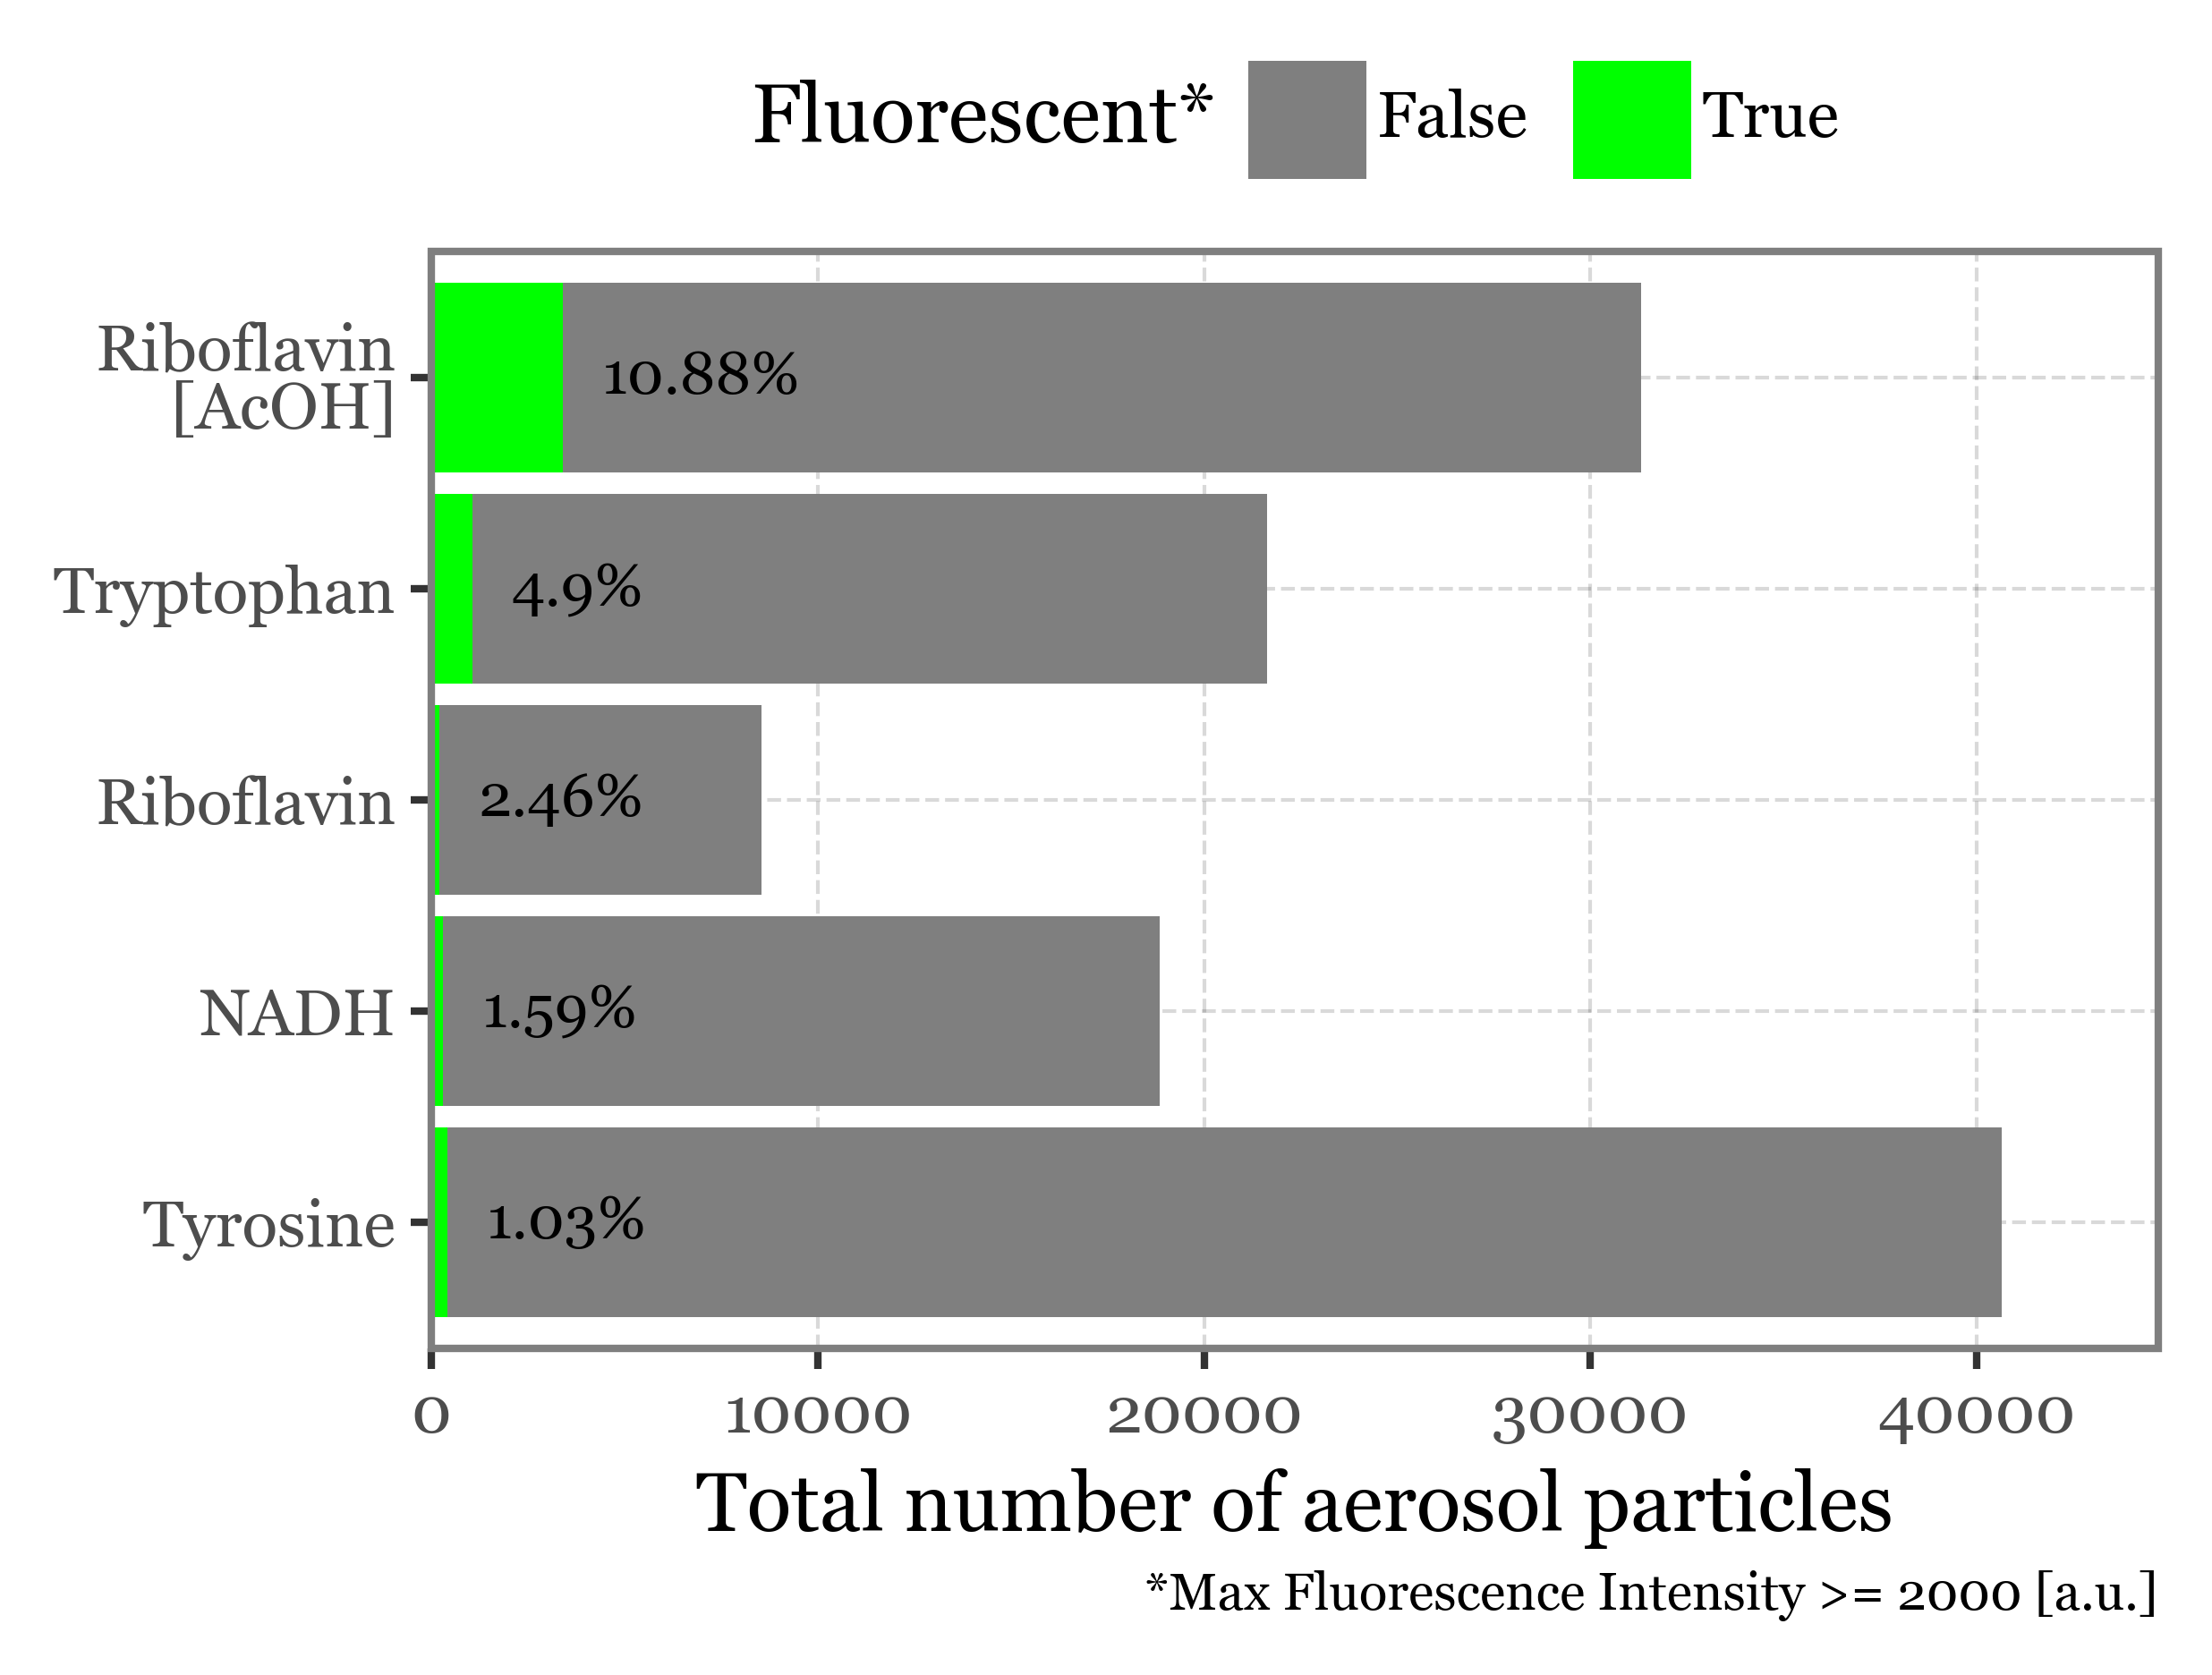

In [181]:
f = (summary_df
 .replace({'fluorophore': {'Riboflavin+acetic': 'Riboflavin\n[AcOH]'}})
 .assign(fluorescent=lambda dd: dd['intensity'] >= 2000)
 .groupby(['fluorophore', 'fluorescent'])
 .size()
 .rename('count')
 .reset_index()
 .assign(percentages=lambda dd: dd.groupby('fluorophore')['count'].transform(lambda x: x / x.sum() * 100).round(2))
 .assign(fluorophore=lambda dd: pd.Categorical(dd['fluorophore'], categories=dd.query('fluorescent').sort_values('percentages')['fluorophore']))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes(x='fluorophore', y='count', fill='fluorescent')
       + p9.geom_col()
       + p9.coord_flip()
       + p9.geom_text(p9.aes(label='percentages.astype(str) + "%"'),
                      nudge_y=1000, size=8, ha='left',
                       data=dd.query('fluorescent'))
       + p9.scale_y_continuous(expand=(0, 0, .1, 0))
       + p9.scale_fill_manual(values=[None, '#00FF00'])
       + p9.labs(x='', y='Total number of aerosol particles', fill='Fluorescent*',
                 caption='*Max Fluorescence Intensity >= 2000 [a.u.]')
       + p9.theme(figure_size=(4, 3), legend_position='top',
                   plot_caption=p9.element_text(size=7))
 )
       )

f.save('../output/figures/fluorophores_fluorescent_counts.svg')
f.draw()

In [157]:
intensity_stats = (summary_df
 .groupby('fluorophore')
 .agg(mean=('intensity', 'mean'),
      median=('intensity', 'median'),
      q95=('intensity', lambda x: np.percentile(x, 95)),
      q99=('intensity', lambda x: np.percentile(x, 99)))
      .reset_index()
)
intensity_stats

,fluorophore,mean,median,q95,q99
0,NADH,694.887509,610.0,1324.0,2360.35
1,Riboflavin,703.847867,557.0,1425.0,3403.46
2,Riboflavin+acetic,1089.236964,634.0,3793.4,8261.40
3,Tryptophan,998.281373,772.0,1983.0,5381.74
4,Tyrosine,676.762471,592.0,1284.0,2028.30


/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3.5 in image.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../output/figures/fluorescence_intensity_histograms.svg
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 329 rows containing non-finite values.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 329 rows containing non-finite values.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 10 rows co

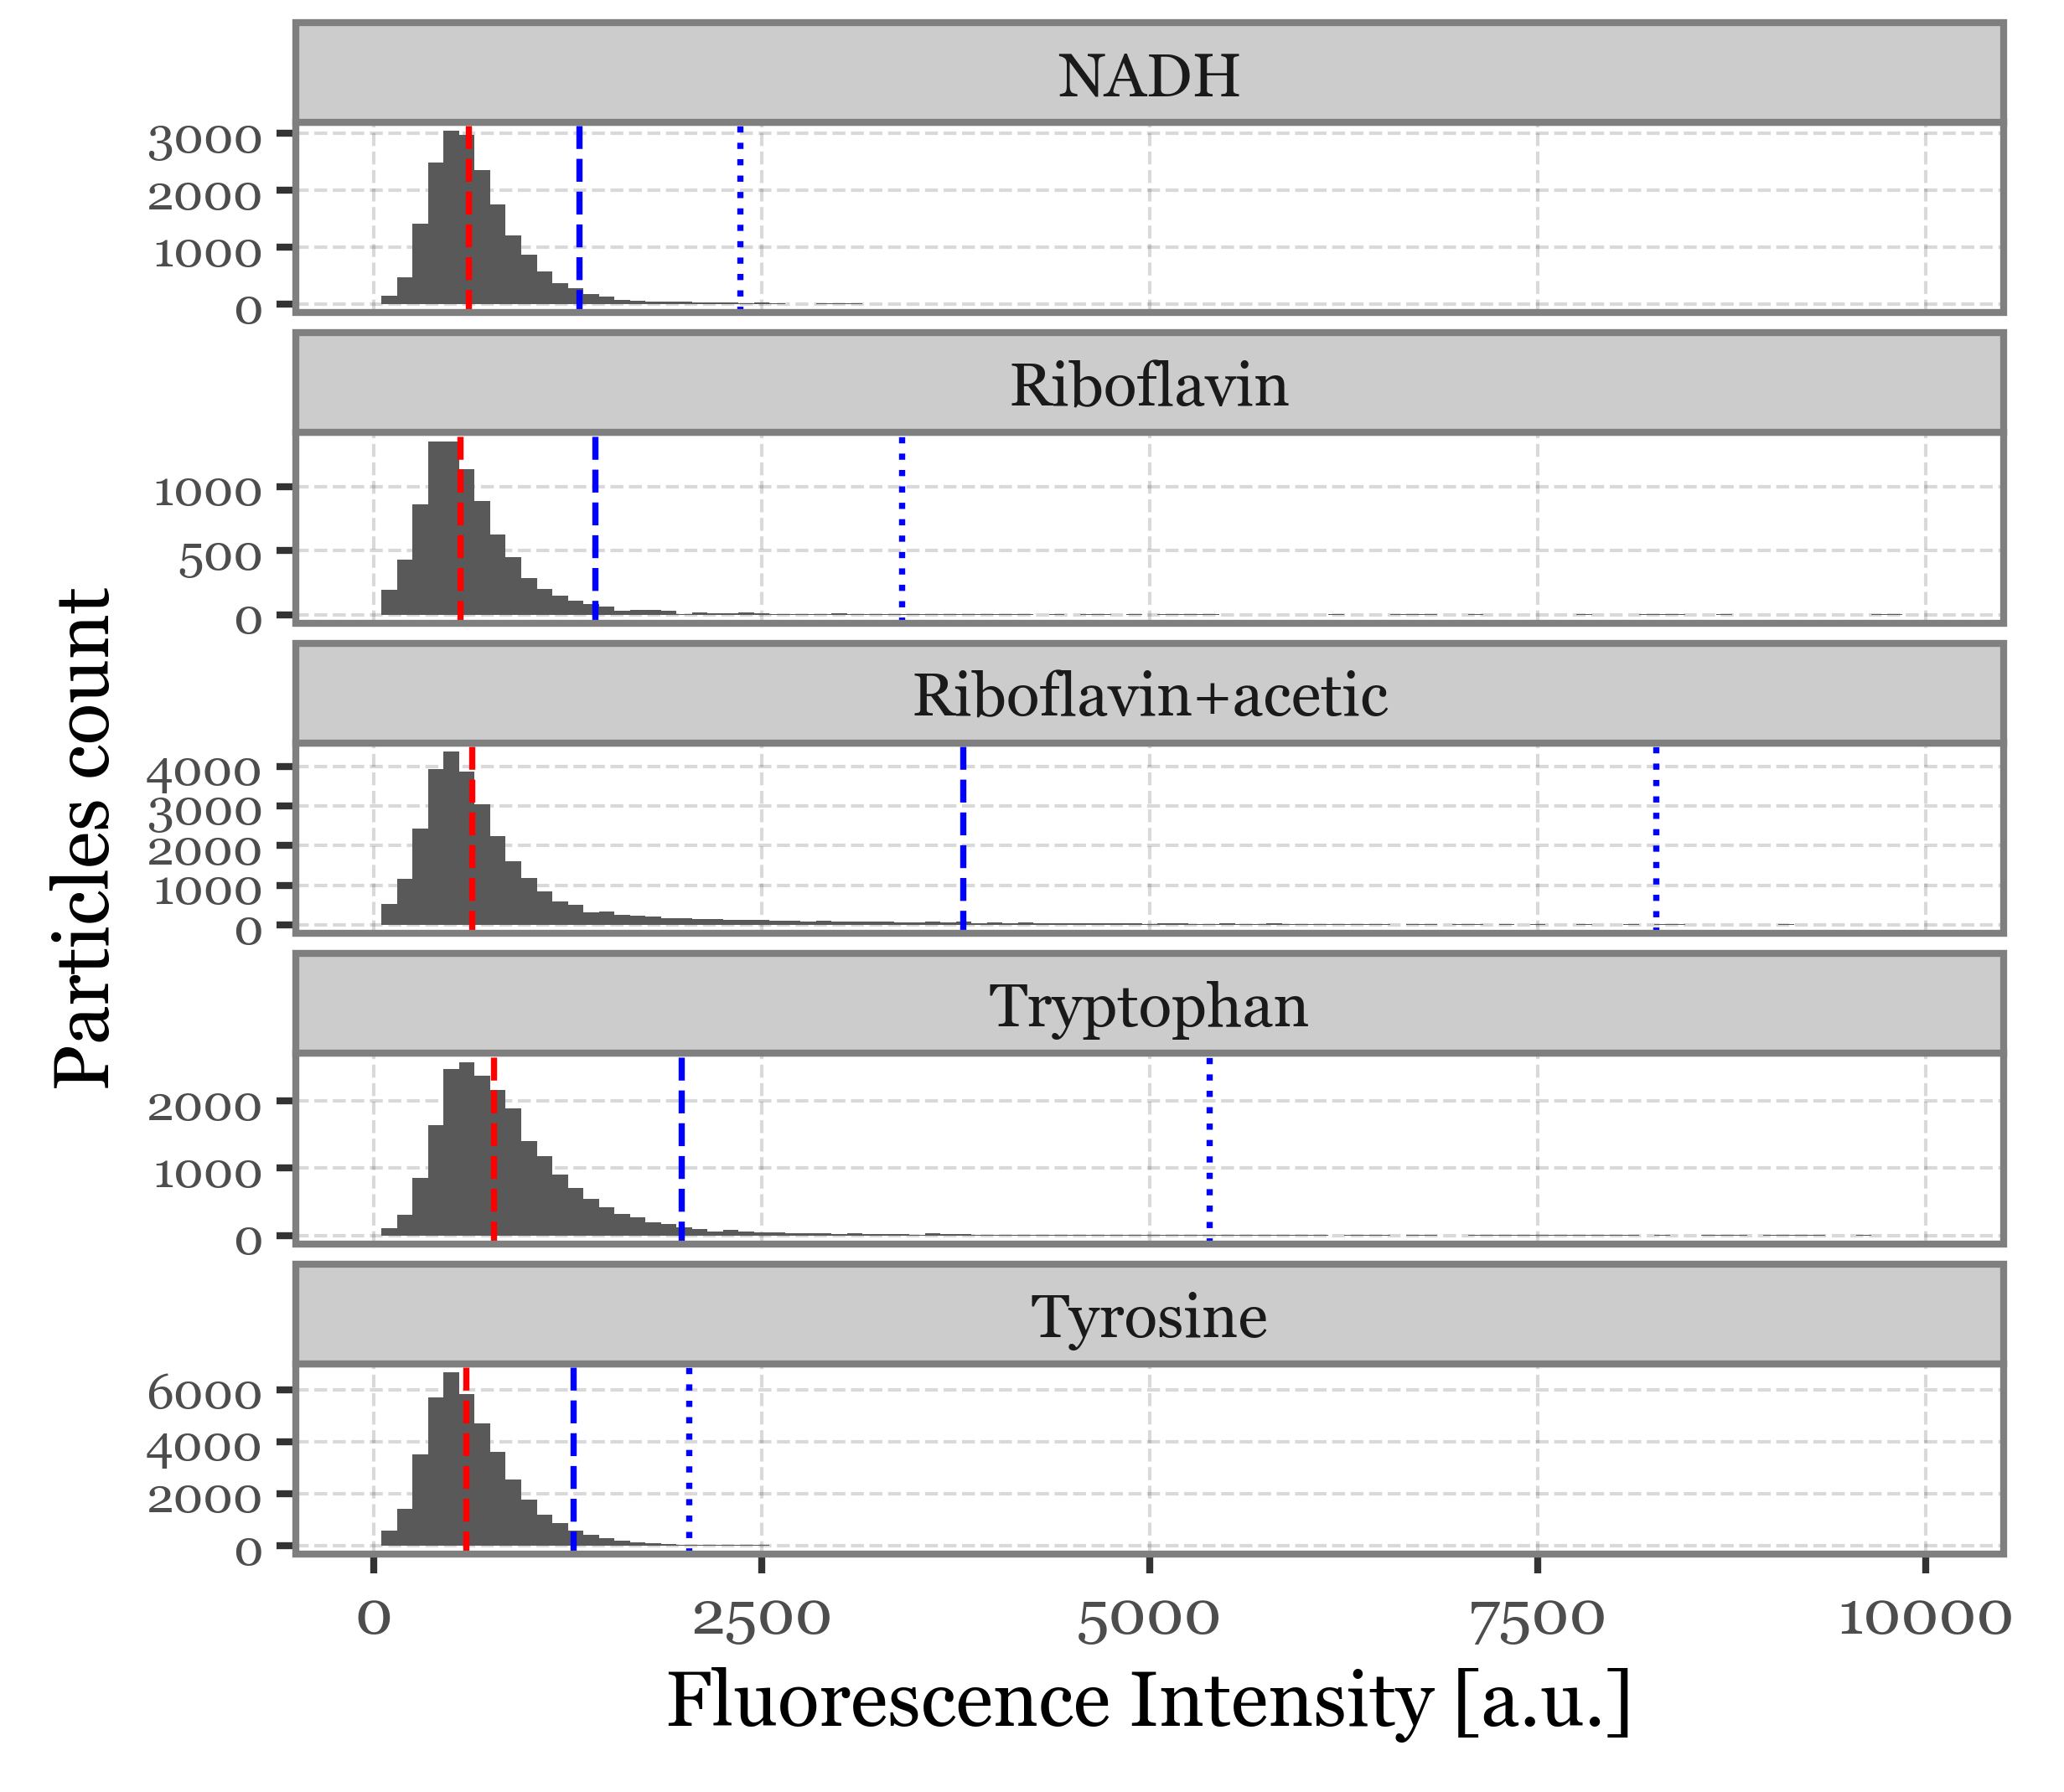

In [183]:
f = (summary_df
 .assign(intensity=lambda dd: dd.intensity.astype(int))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.geom_histogram(p9.aes(x='intensity'), binwidth=100)
       + p9.facet_wrap('fluorophore', ncol=1, scales='free_y')
       + p9.geom_vline(p9.aes(xintercept='median'), color='red', linetype='dashed',
                       data=intensity_stats)
       + p9.geom_vline(p9.aes(xintercept='q95'), color='blue', linetype='dashed',
                          data=intensity_stats)
       + p9.geom_vline(p9.aes(xintercept='q99'), color='blue', linetype='dotted',
                       data=intensity_stats)
       + p9.labs(x='Fluorescence Intensity [a.u.]', y='Particles count')
       + p9.scale_x_continuous(limits=(0, 10000))
       + p9.theme(figure_size=(4, 3.5),
                  axis_text_y=p9.element_text(size=7))
 )
)
f.save('../output/figures/fluorescence_intensity_histograms.svg')
f.draw()

In [8]:
particles_dict['Tyrosine'].filter('intensity > 3000')

Filtering particles with query: intensity > 3000


Collection of 179 aerosol particles measured from 2021-01-27 15:44:02 to 2021-01-27 15:53:58.

In [9]:
fluo_particles_dict = {}
for fluorophore, particles in particles_dict.items():
    fluo_particles_dict[fluorophore] = particles.filter('intensity >= 2000')

Filtering particles with query: intensity >= 2000
Filtering particles with query: intensity >= 2000
Filtering particles with query: intensity >= 2000
Filtering particles with query: intensity >= 2000
Filtering particles with query: intensity >= 2000


In [63]:
super_fluo_particles_dict = {}
for fluorophore, particles in particles_dict.items():
    super_fluo_particles_dict[fluorophore] = particles.filter('intensity >= 2500')

Filtering particles with query: intensity >= 2500
Filtering particles with query: intensity >= 2500
Filtering particles with query: intensity >= 2500
Filtering particles with query: intensity >= 2500
Filtering particles with query: intensity >= 2500


In [64]:
spectra_df = []
for fluorophore in super_fluo_particles_dict:
    for i, particle in enumerate(super_fluo_particles_dict[fluorophore]):
        spectra_df.append(particle.spectrum_time_matrix.sum(axis=1)
                  .rename('intensity')
                  .reset_index()
                  .assign(relative_intensity=lambda dd: dd['intensity'] / dd['intensity'].max())
                  .assign(fluorophore=fluorophore)
                  .assign(particle_index=i)
                  .assign(max_intensity=lambda dd: dd['intensity'].max())
 )
spectra_df = pd.concat(spectra_df)

/var/folders/st/cmjs4m0d5_x9cct52wfljtvm0000gn/T/ipykernel_2558/3185892512.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../output/figures/fluorophores_fluorescence_spectra.svg


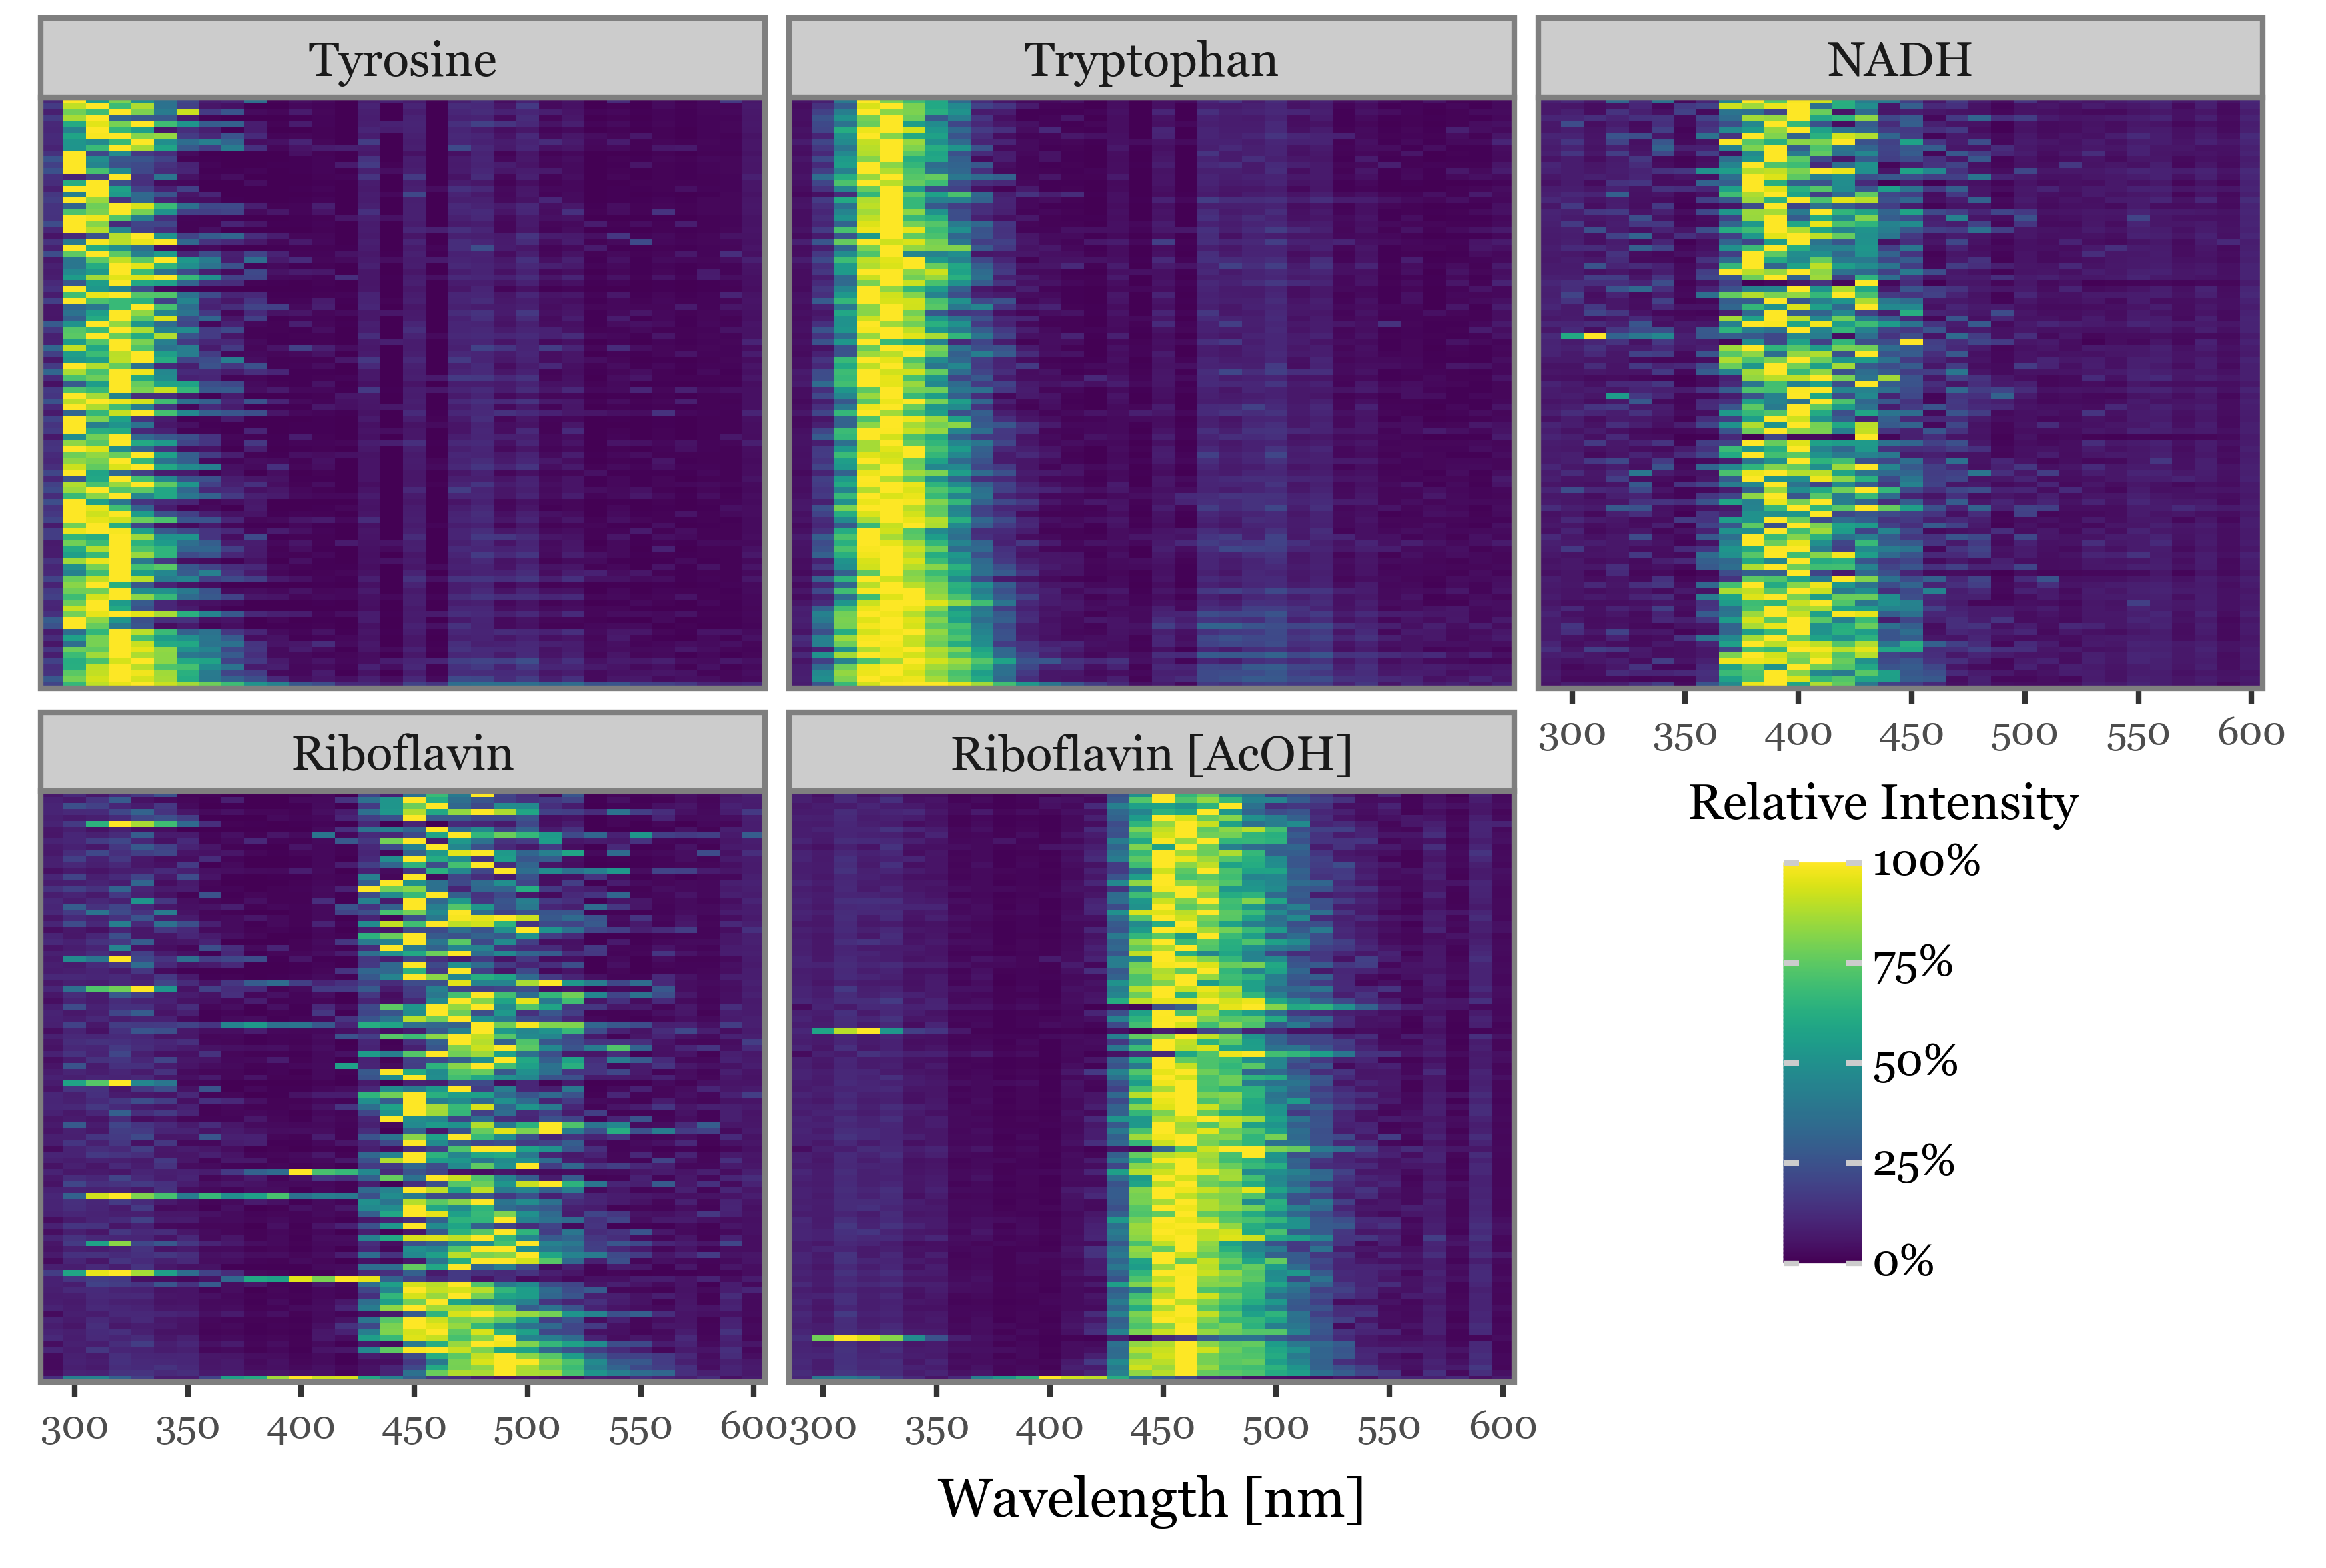

In [66]:
n = 100
selected_particles = (spectra_df
 .groupby('fluorophore')
 .apply(lambda dd: dd[['particle_index', 'max_intensity']].drop_duplicates()
        .sort_values('max_intensity', ascending=False)
        .head(n).assign(new_index=range(n)))
        .reset_index()
 [['fluorophore', 'particle_index', 'new_index']]
)


f = (spectra_df
 .merge(selected_particles, on=['fluorophore', 'particle_index'])
 .replace('Riboflavin+acetic', 'Riboflavin [AcOH]')
 .assign(fluorophore=lambda dd: pd.Categorical(dd['fluorophore'], categories= [
     'Tyrosine', 'Tryptophan', 'NADH', 'Riboflavin', 'Riboflavin [AcOH]'
 ]))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes(x='wavelength', y='new_index')
         + p9.geom_tile(p9.aes(fill='relative_intensity'))
         + p9.scale_x_continuous(expand=(0, 0), breaks=range(300, 601, 50))
         + p9.scale_y_continuous(expand=(0, 0))
         + p9.scale_fill_cmap('viridis', labels=percent_format())
         + p9.facet_wrap('fluorophore')
         + p9.labs(x='Wavelength [nm]', fill='Relative Intensity')
         + p9.theme(axis_text_y=p9.element_blank(),
                      axis_title_y=p9.element_blank(),
                      axis_ticks_major_y=p9.element_blank(),
                      legend_position=(.9, .125),
                      legend_key_size=10,
                      legend_text=p9.element_text(size=8),
                      legend_title=p9.element_text(size=9, ha='center'),
                      axis_title_x=p9.element_text(size=10, va='top'),
                      axis_text_x=p9.element_text(size=7),
                      figure_size=(6, 4),
                      plot_margin=.03
         )
 )
)
f.save('../output/figures/fluorophores_fluorescence_spectra.svg')
f.draw()

/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/alejandro/miniconda3/envs/kd-spatial-ts/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../output/figures/fluorophores_fluorescence_spectra_median.svg


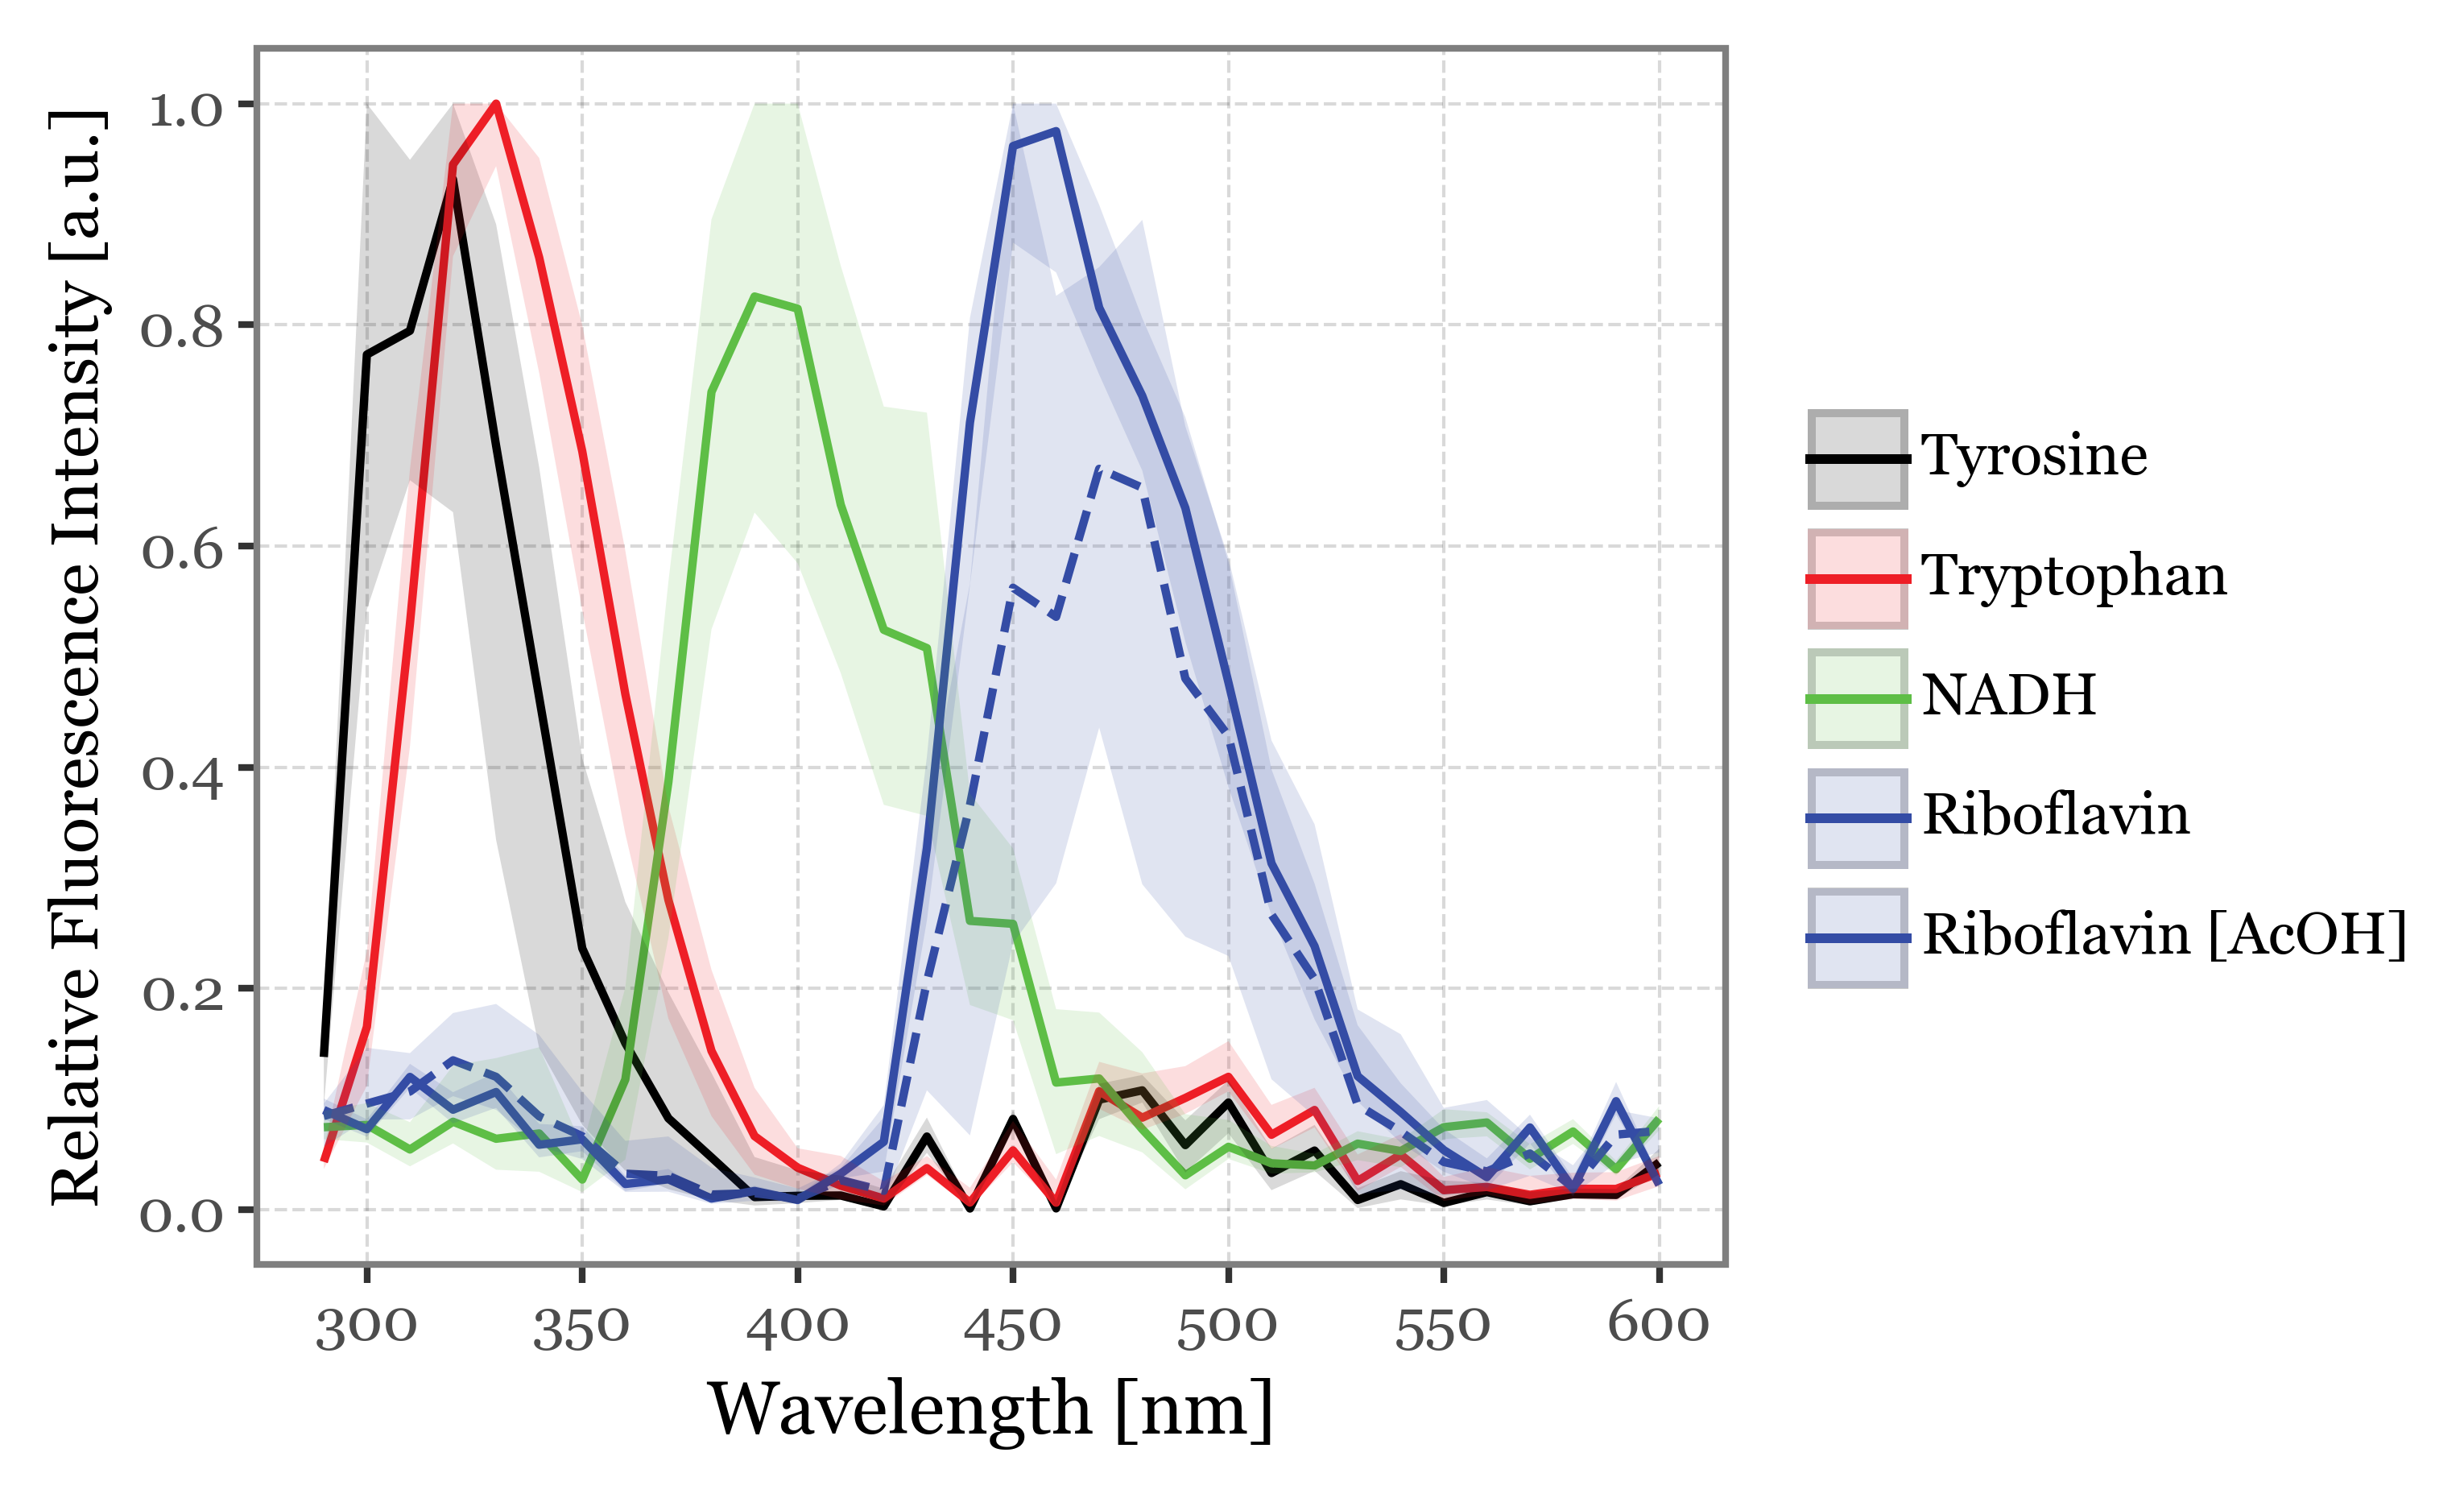

In [68]:
f = (spectra_df
 .merge(selected_particles, on=['fluorophore', 'particle_index'])
 .replace('Riboflavin+acetic', 'Riboflavin [AcOH]')
 .assign(fluorophore=lambda dd: pd.Categorical(dd['fluorophore'], categories= [
     'Tyrosine', 'Tryptophan', 'NADH', 'Riboflavin', 'Riboflavin [AcOH]'
 ]))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes(x='wavelength', y='relative_intensity')
       + p9.scale_color_manual(['black', '#EE1E26', '#5EBE46', '#344CA5', "#344CA5"])
       + p9.scale_fill_manual(['black', '#EE1E26', '#5EBE46', '#344CA5', "#344CA5"])
       + p9.scale_x_continuous(breaks=range(300, 601, 50))
       + p9.scale_y_continuous(breaks=[0, .2, .4, .6, .8, 1])
       + p9.labs(y='Relative Fluorescence Intensity [a.u.]', x='Wavelength [nm]', color='', fill='')
       + p9.stat_summary(geom='line', size=.7, fun_y=np.median, mapping=p9.aes(color='fluorophore', linetype='fluorophore=="Riboflavin"'))
       + p9.stat_summary(fun_ymax=lambda x: x.quantile(.75),
                         fun_ymin=lambda x: x.quantile(.25),
                          geom='ribbon', alpha=.15, mapping=p9.aes(fill='fluorophore'))
       + p9.guides(linetype=False)
       + p9.theme(figure_size=(5, 3),
                  axis_title_y=p9.element_text(size=10),
       )
    )
       )
f.save('../output/figures/fluorophores_fluorescence_spectra_median.svg')
f.draw()

In [75]:
lifetimes = []
for fluorophore, particles in super_fluo_particles_dict.items():
    selected_idxs = selected_particles.query('fluorophore == @fluorophore')['particle_index']
    for i in selected_idxs:
        particle = particles[i]
        lifetimes.append(particle.lifetime
                         .assign(fluorophore=fluorophore)
                         .assign(particle_index=i)
        )
lifetimes = pd.concat(lifetimes)

In [76]:
lifetime_stats = (lifetimes
 .replace({'350-400 nm': '300-340 nm'})
 .groupby(['fluorophore', 'time', 'wavelength_range'], as_index=False)
 .agg(
     median=('intensity', 'median'),
    q05=('intensity', lambda x: x.quantile(.05)),
    q25=('intensity', lambda x: x.quantile(.25)),
    q75=('intensity', lambda x: x.quantile(.75)),
    q95=('intensity', lambda x: x.quantile(.95)),
 )
)

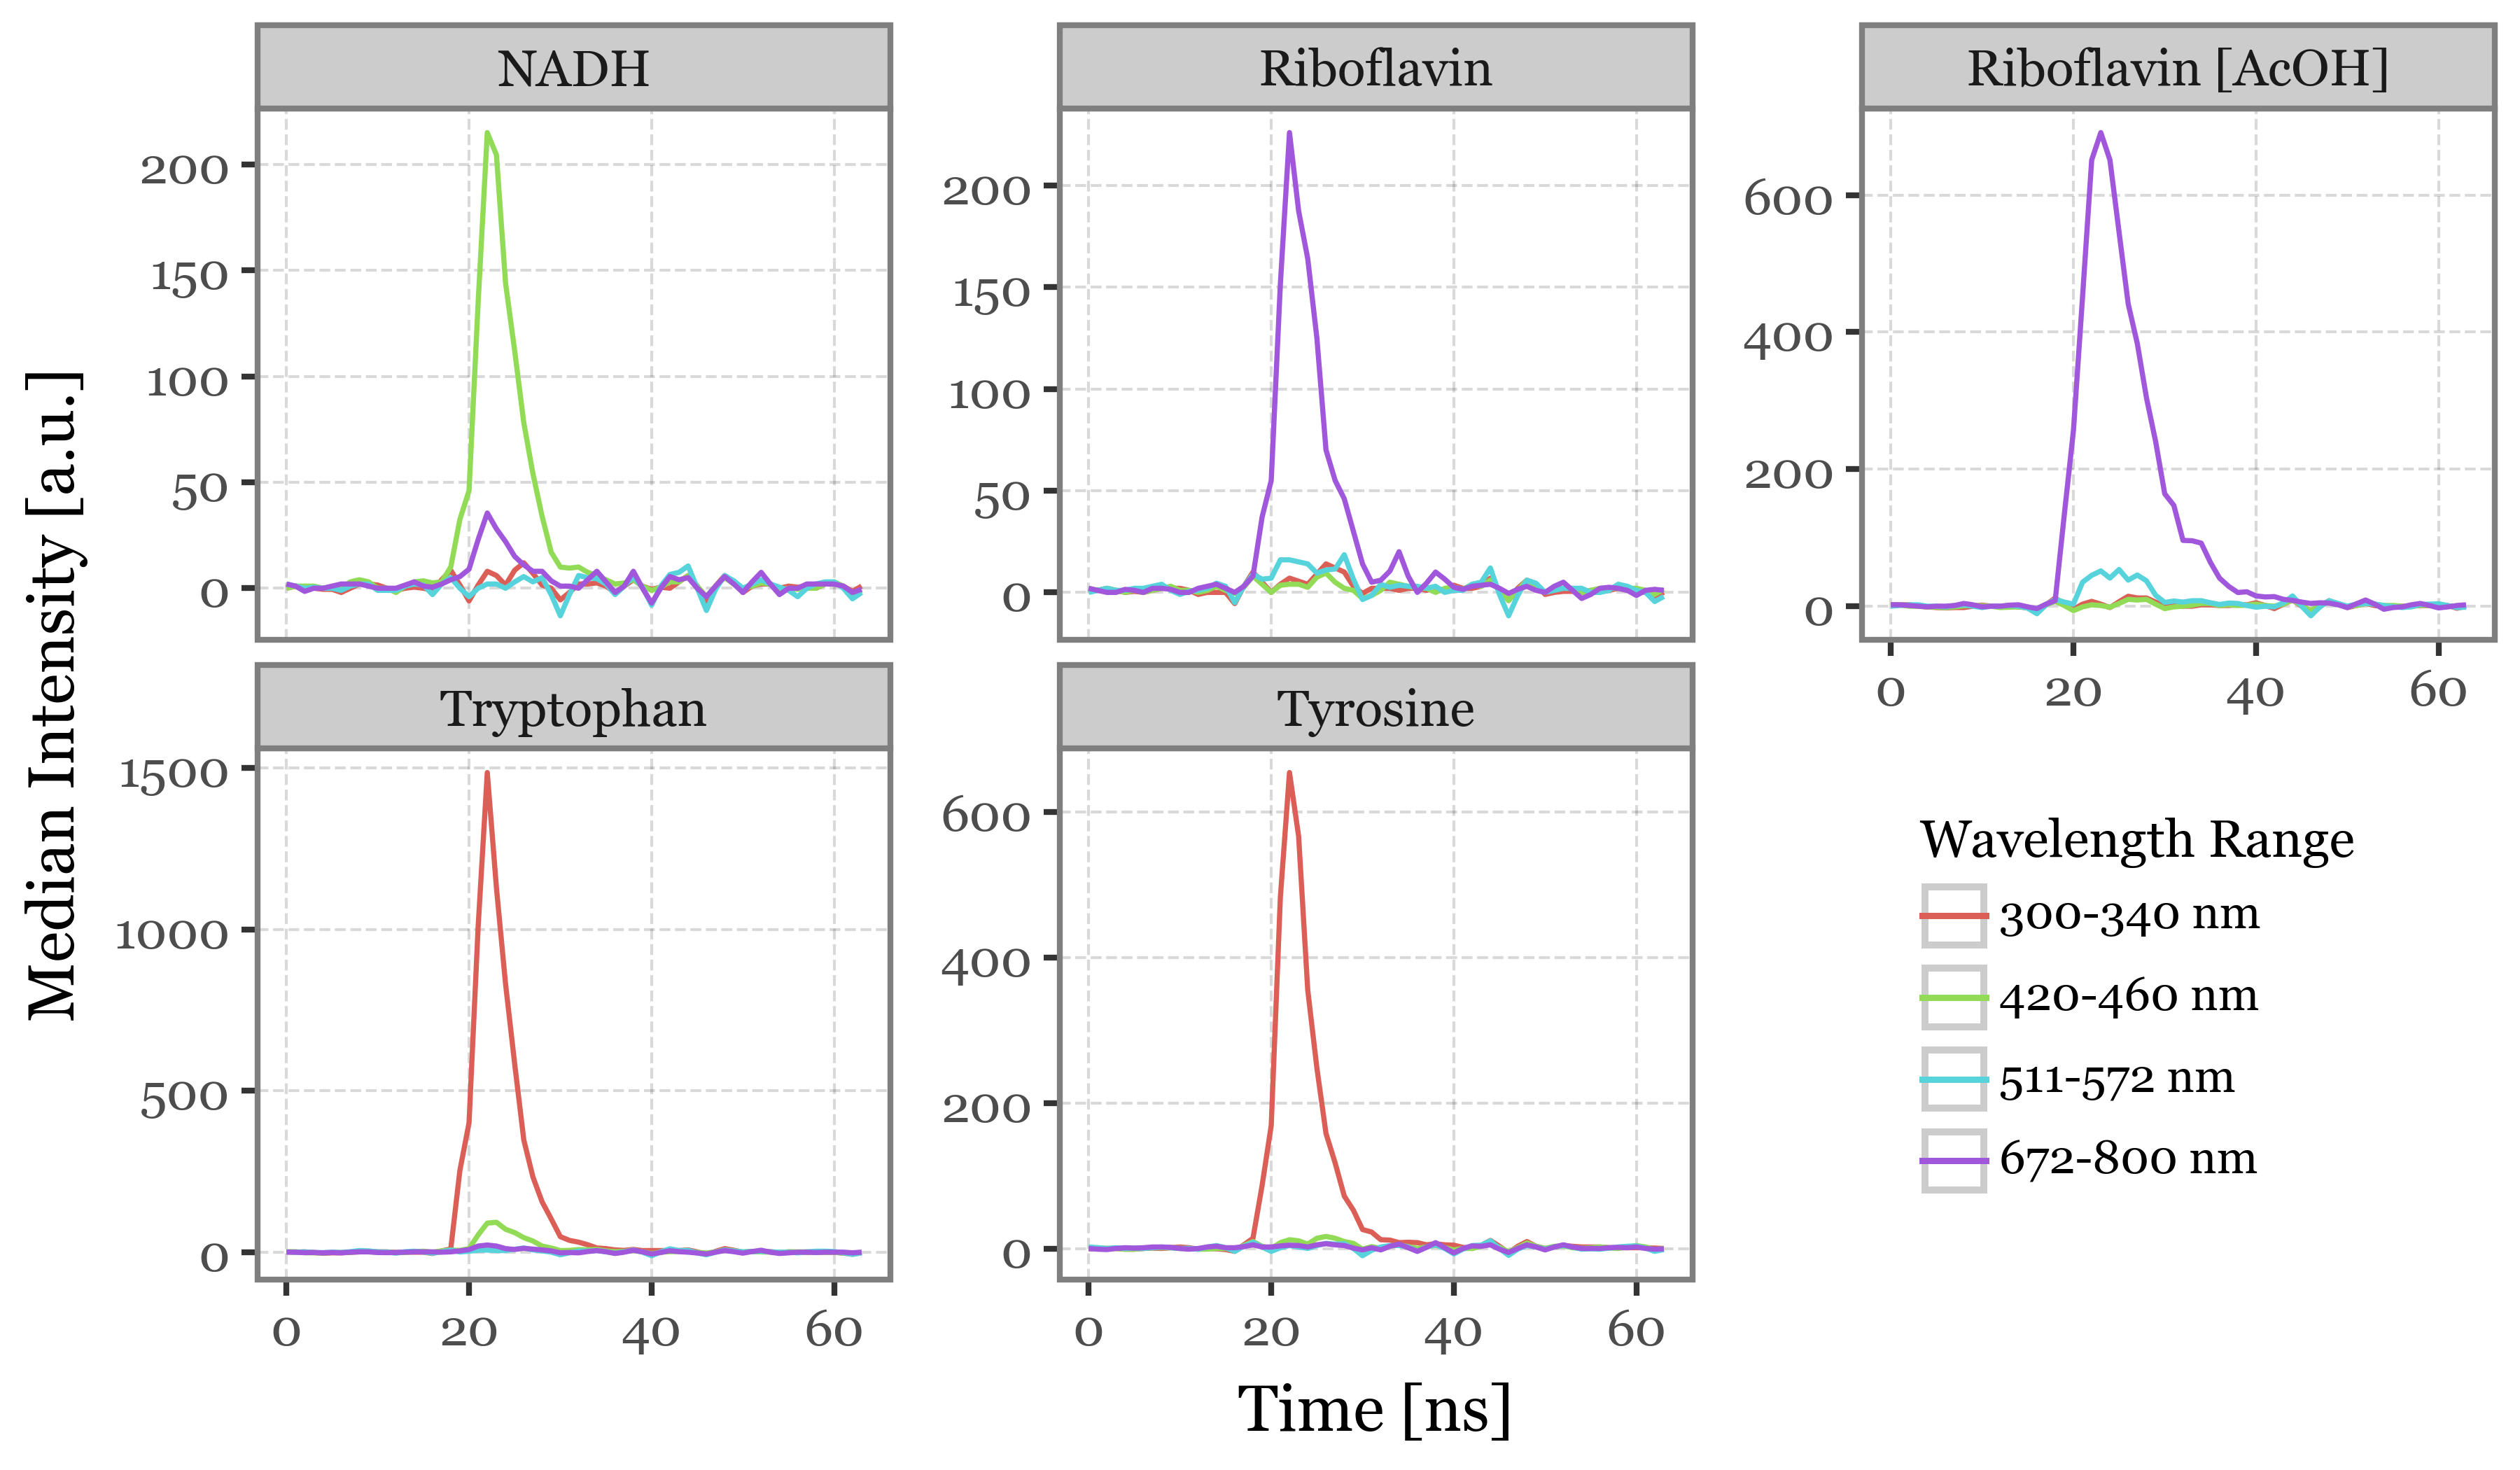

In [86]:
(lifetime_stats
 .replace('Riboflavin+acetic', 'Riboflavin [AcOH]')
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes(x='time', y='median', color='wavelength_range')
       + p9.geom_line()
       + p9.facet_wrap('fluorophore', ncol=3, scales='free_y')
       + p9.labs(x='Time [ns]', y='Median Intensity [a.u.]', color='Wavelength Range')
       + p9.theme(
           legend_position=(.925, .1),
           figure_size=(6, 3.5),
           legend_title=p9.element_text(size=9),
           legend_text=p9.element_text(size=8),
           legend_key_size=12,
                  )
 )
)